# Machine learning with uncertainties
Develop machine-learning models to predict capacity from EIS data.

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from eis.eisplot import plot_eis

In [2]:
# Load data
eis_data = pd.read_csv("data\data_eis_zhang2020.csv")
freq = np.loadtxt("data/freq_eis_zhang2020.csv")

## Processing impedance data

In [3]:
eis_data

,seriesIdx,cycle,Q,q,ZReal_2e+04Hz,ZReal_1.6e+04Hz,ZReal_1.3e+04Hz,ZReal_9.9e+03Hz,ZReal_7.8e+03Hz,ZReal_6.2e+03Hz,...,ZPhase_0.16Hz,ZPhase_0.13Hz,ZPhase_0.1Hz,ZPhase_0.082Hz,ZPhase_0.064Hz,ZPhase_0.051Hz,ZPhase_0.04Hz,ZPhase_0.032Hz,ZPhase_0.025Hz,ZPhase_0.02Hz
0,1,1,37.202713,1.000000,0.38470,0.39156,0.39684,0.40341,0.40963,0.41925,...,-4.64991,-5.30007,-6.04115,-6.81063,-7.74326,-8.84087,-10.34293,-11.96089,-13.36154,-14.62612
1,1,2,36.223033,0.973666,0.38886,0.39343,0.40066,0.40798,0.41472,0.42210,...,-4.65772,-5.39308,-6.16969,-6.99397,-7.90025,-8.87584,-10.18786,-11.55280,-12.77350,-14.15406
2,1,3,35.589301,0.956632,0.39038,0.39600,0.40250,0.40874,0.41617,0.42422,...,-4.68194,-5.24803,-5.99357,-6.99463,-8.11983,-9.12763,-10.15053,-11.47981,-13.00974,-14.46611
3,1,4,35.108081,0.943697,0.39194,0.39643,0.40406,0.41059,0.41739,0.42510,...,-4.67762,-5.30371,-6.06182,-6.87801,-7.82632,-8.77240,-10.15570,-11.83933,-13.39306,-14.71820
4,1,5,34.767280,0.934536,0.39225,0.39760,0.40540,0.41088,0.41967,0.42648,...,-4.67169,-5.38683,-6.19985,-7.00461,-7.90794,-8.89791,-10.19660,-11.53191,-12.75012,-14.07858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,8,33,26.132831,0.769888,0.29341,0.30111,0.31036,0.31984,0.33009,0.34109,...,-4.71999,-4.99432,-5.47044,-6.17900,-7.00352,-7.74423,-8.59897,-9.76230,-11.08951,-12.31088
1339,8,34,25.944533,0.764341,0.29167,0.29918,0.30999,0.31893,0.32766,0.34011,...,-4.75800,-5.13854,-5.62865,-6.15538,-6.81165,-7.61852,-8.68868,-9.83151,-10.86969,-12.10385
1340,8,35,25.785219,0.759647,0.29397,0.30078,0.30868,0.31924,0.32921,0.34087,...,-4.79288,-5.03128,-5.45907,-6.15225,-7.01546,-7.86920,-8.71853,-9.77307,-11.11300,-12.47591
1341,8,36,25.838960,0.761231,0.29174,0.29957,0.30764,0.31867,0.32771,0.33902,...,-4.86304,-5.19768,-5.59992,-6.10129,-6.83359,-7.77428,-8.75583,-9.72542,-10.94839,-12.57540


There are several variables in this data frame:
- seriesIdx: index denoting which cell (1-8) was recorded from
- cycle: cycle number count
- Q: capacity of the cell in mAh
- q: relative capacity of each cell (capacity divided by initial capacity, calculated for each cell)
- ZReal_xHz: real component of the impedance at x Hz frequency
- ZImag_xHz: imaginary component of the impedance at x Hz frequency
- Z_xHz: magnitude of the impedance at x Hz frequency
- ZPhase_xHz: phase angle of the impedance at x Hz frequency

So, for training a model, the target variable is q, while the features are all the components of the measured impedance at each frequency. The frequency vector for these measurements can be created using `np.logspace` or loaded from file.

In [4]:
freq.shape, np.max(freq), np.min(freq)

((60,), 20004.453, 0.01999)

In [5]:
y = eis_data['Q']
is_Z_col = eis_data.columns.str.contains('Z')
x = eis_data[eis_data.columns[is_Z_col]]
y.shape, x.shape

((1343,), (1343, 240))

The data is now extracted, and the shapes look correct (same number of rows in x and y, 240 columns in x corresponds to 4 components of the impedance for 60 frequencies).

To plot the impedance data, we need to reform these features into arrays of complex numbers.

In [6]:
is_ZReal_col = x.columns.str.contains('ZReal')
is_ZImag_col = x.columns.str.contains('ZImag')
eis = x.apply(lambda d: d[is_ZReal_col].values + 1j*d[is_ZImag_col].values, axis=1)
eis[0].shape

(60,)

## Visualizing impedance data
Visualizing the raw data can help us understand the complexity of the problem. Plotting just one curve gives us an idea of the typical 'shape' of an impedance measurement, as well as the relationships between the components of the impedance. |Z| and Z_Real are both 'magnitude' features, which are always increasing as frequency decreases, while Z_Imaginary and phase of Z are both 'phase' features, which vary non-monotonically versus frequency.

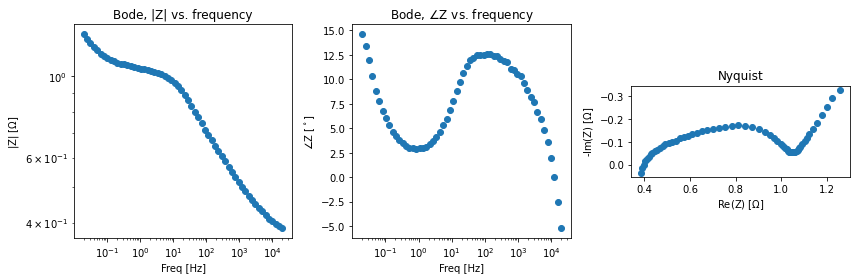

In [7]:
plot_eis(freq, eis[0])

Plotting all of the data for one of the cells can help us understand how capacity and impedance vary throughout the lifetime of a cell.

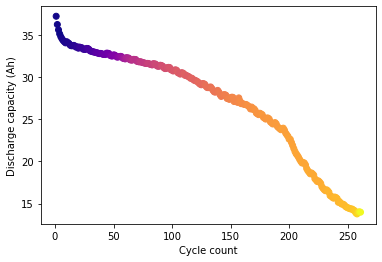

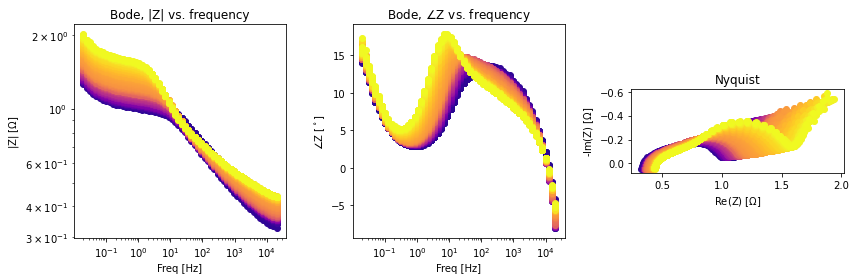

In [8]:
maskSeries = eis_data.seriesIdx == 1

plt.scatter(eis_data.cycle[maskSeries], eis_data.Q[maskSeries],
            c=np.flip(eis_data.Q[maskSeries]), cmap='plasma')
plt.xlabel('Cycle count')
plt.ylabel('Discharge capacity (Ah)')

plot_eis(freq, eis[maskSeries], cmap='plasma')

Impedance seems to be increasing throughout the lifetime of the cell. Also, the locations of peaks and valleys in the phase of Z and Z_Imaginary seem to vary. 

Let's plot the data from one more cell.

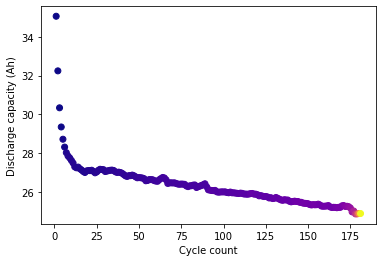

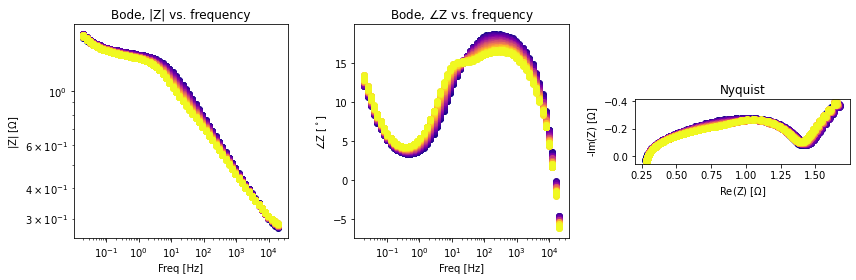

In [9]:
maskSeries = eis_data.seriesIdx == 2

plt.scatter(eis_data.cycle[maskSeries], eis_data.Q[maskSeries],
            c=np.flip(eis_data.Q[maskSeries]), cmap='plasma')
plt.xlabel('Cycle count')
plt.ylabel('Discharge capacity (Ah)')

plot_eis(freq, eis[maskSeries], cmap='plasma')

This battery fails almost immediately, and has very little change to impedance. Actually, the impedance has decreased slightly.

The wide variance between trends implies that it should be challenging to predict capacity from impedance.

## Training a model

We can train a simple linear model predicting capacity with very lines of code using sklearn. Best practice is to normalize the input features before training.

In [10]:
# Import regression model class
from sklearn.linear_model import LinearRegression
# Import data normalization tool
from sklearn.preprocessing import StandardScaler
# Import standard statistical metrics for evaluating model performance
from sklearn.metrics import mean_absolute_error, r2_score

In [11]:
# Normalize the training data
scaler = StandardScaler()
x_ = scaler.fit_transform(x)
# Instantiate the linear model class object
regressor = LinearRegression()
# Fit the linear model
regressor.fit(x_, y)
# Make the predictions using the fit model
y_pred = regressor.predict(x_)
print("MAE: %0.2f, R^2: %0.2f" % (mean_absolute_error(y, y_pred), r2_score(y, y_pred)))

MAE: 0.36, R^2: 0.99


In [12]:
# Define a function to plot results, we're going to do this more than once
def plotyy(y, y_pred, c, title=None):
    plt.set_cmap('tab10')
    fig, ax = plt.subplots(1,1)
    ax.scatter(y.values, y_pred, c=c)
    ax.set_aspect('equal')
    plt.xlabel('Actual discharge capacity (Ah)')
    plt.ylabel('Predicted discharge capacity(Ah)')
    plt.axis('square')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    lims = np.concatenate((xlim, ylim))
    lims = np.array([min(lims), max(lims)])
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_autoscale_on(False)
    plt.plot([-100, 100], [-100,100], '--k')
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()

<Figure size 432x288 with 0 Axes>

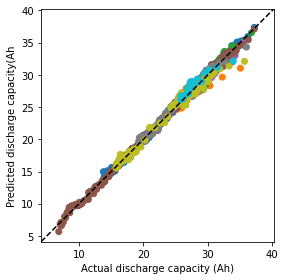

In [13]:
plotyy(y, y_pred, eis_data.seriesIdx)

While this looks impressive, it's seems suspiciously good. Should we really be able to predict the capacity of a battery with such high accuracy after making so little effort?

One common method to test our model performance is to hold out data from training to test a model on, i.e., the test set. A common way to test a model is to randomly hold out some fraction of the data.

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_, y,
    test_size=0.3, random_state=42)

x_train.shape, x_test.shape

((940, 240), (403, 240))

MAE: 0.46, R^2: 0.99


<Figure size 432x288 with 0 Axes>

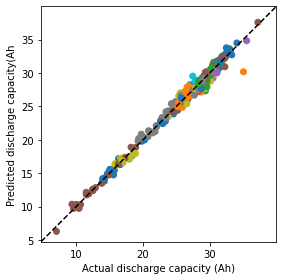

In [15]:
# Train
regressor.fit(x_train, y_train)
# Test
y_test_pred = regressor.predict(x_test)
print("MAE: %0.2f, R^2: %0.2f" % (mean_absolute_error(y_test, y_test_pred), r2_score(y_test, y_test_pred)))
# Note we can access the seriesIdx using the indices of the test dataframe, as sklearn plays very nicely with pandas
plotyy(y_test, y_test_pred, eis_data.seriesIdx[y_test.index])

This is only a tiny bit worse. Our simple data exploration seemed to suggest that this should be challenging task.

Here, it turns out that our test set is actually not very difficult - we are simply picking points at random, regardless of what cell they are from. In the 'real world', we need to predict the capacity of cells that we have no capacity data for.

### Predicting capacity from unseen cells
When predicting from new data, we have the additional complication of having to 'train' any data transformations, and then replicated them on the test set. For instance, we should normalize our data only using information from the training set, and then transform the test set data accordingly. This practice prevents 'data leakage', e.g., spurious correlations - we don't want **any** information from the test data to affect our model during training; if we normalize the entire data set at once, we are including statistical information about the test data into the normalization statistics.

<Figure size 432x288 with 0 Axes>

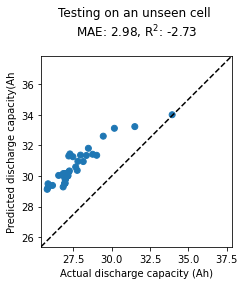

In [16]:
# Use the last cell for testing
is_train = eis_data.seriesIdx != eis_data.seriesIdx.iloc[-1]
x_train, x_test, y_train, y_test = x[is_train], x[~is_train], y[is_train], y[~is_train]
# Standardize the training data
scaler = StandardScaler()
x_train_ = scaler.fit_transform(x_train)
# Train
regressor.fit(x_train_, y_train)
# Test
x_test_ = scaler.transform(x_test)
y_test_pred = regressor.predict(x_test_)
title = "Testing on an unseen cell \n" r"MAE: %0.2f, R$^2$: %0.2f" % (mean_absolute_error(y_test, y_test_pred), r2_score(y_test, y_test_pred))
plotyy(y_test, y_test_pred, eis_data.seriesIdx[y_test.index], title=title)

We could also plot the actual and predicted versus cycle count:

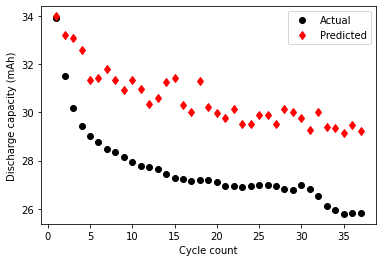

In [17]:
plt.plot(eis_data.cycle[y_test.index], y_test, 'ok')
plt.plot(eis_data.cycle[y_test.index], y_test_pred, 'dr')
plt.xlabel('Cycle count')
plt.ylabel('Discharge capacity (mAh)')
plt.legend(('Actual', 'Predicted'))

We should also always be comparing results with some kind of baseline, to contextualize the error statistics. For this relatively straightforward problem, it's not hard that hard to contextualize the results, but for more complex problems, it can be difficult to understand the error statistics. It's also simply best practice to make sure your models are outperforming extremely simple approaches. There are several 'dummy' model types available in sklearn to compare against.

<Figure size 432x288 with 0 Axes>

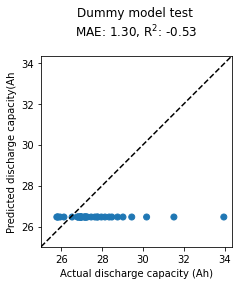

In [18]:
from sklearn.dummy import DummyRegressor

# Use the last cell for testing
is_train = eis_data.seriesIdx != eis_data.seriesIdx.iloc[-1]
x_train, x_test, y_train, y_test = x[is_train], x[~is_train], y[is_train], y[~is_train]
# Standardize the training data
scaler = StandardScaler()
x_train_ = scaler.fit_transform(x_train)
# Train
dummy_regr = DummyRegressor(strategy='mean') # this is the default setting
dummy_regr.fit(x_train_, y_train)
# Test
x_test_ = scaler.transform(x_test)
y_test_pred = dummy_regr.predict(x_test_)
title = "Dummy model test \n" r"MAE: %0.2f, R$^2$: %0.2f" % (mean_absolute_error(y_test, y_test_pred), r2_score(y_test, y_test_pred))
plotyy(y_test, y_test_pred, eis_data.seriesIdx[y_test.index], title=title)

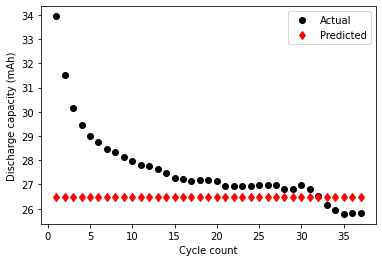

In [19]:
# Capacity vs. cycle plot
fig, ax = plt.subplots(1,1)
plt.plot(eis_data.cycle[y_test.index], y_test, 'ok')
plt.plot(eis_data.cycle[y_test.index], y_test_pred, 'dr')
plt.xlabel('Cycle count')
plt.ylabel('Discharge capacity (mAh)')
plt.legend(('Actual', 'Predicted'))

It's pretty clear that this model is no longer working well - the dummy model is actually performing better (MAE of 1.3 mAh, vs. 3 mAh for the linear model). But our test set is quite limited. We want to know how well this model performs on **any** unseen cell, not just **one** unseen cell. For this, we can use cross-validation, where we repeat this process, but holding out each cell in turn for testing and training on the other cells. But recall that we need to 'train' the data standardization for each training set, as well. It's not too hard to imagine how this process would work, but it is quite a few lines of code. Thankfully, sklearn automates this process using 'Pipelines'.

### Model pipelines

We can set up a simple example pipeline using the easy train/test split from earlier (randomized splitting by data point). Below is one way to instantiate a pipeline. You can also use the `make_pipeline()` method.

<Figure size 432x288 with 0 Axes>

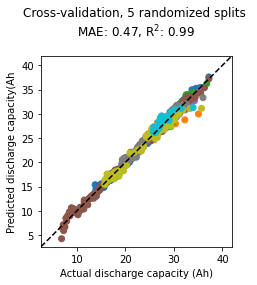

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

# Instatiate the pipeline object
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ]
)
# Run cross-validation
# Default is 5 randomized splits, e.g., a 80/20 train/test split repeated 5 times, with non-overlapping splits
# Here we instantiate the KFold CV-splitter object so that we can define the random seed for replicability
y_pred = cross_val_predict(pipe, x, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))
title = "Cross-validation, 5 randomized splits \n" r"MAE: %0.2f, R$^2$: %0.2f" % (mean_absolute_error(y, y_pred), r2_score(y, y_pred))
plotyy(y, y_pred, eis_data.seriesIdx, title=title)

Note that while we are plotting the entire data set, every one of these predictions is a 'test' prediction. Again, with splits randomized by data point and no domain context (knowledge of which cell each data point is from), it looks like we have a very good model. We can test how well the model performns when being split on a cell basis, i.e., our seriesIdx variable, using functionality already built in.

<Figure size 432x288 with 0 Axes>

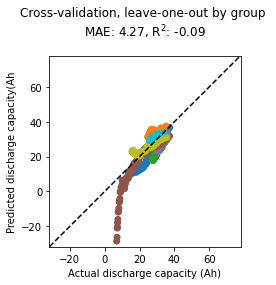

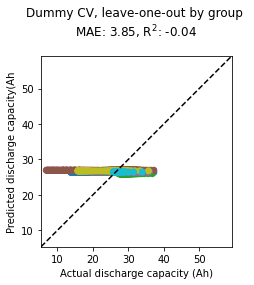

In [21]:
from sklearn.model_selection import LeaveOneGroupOut

# Instatiate the pipeline object
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ]
)
# Also make a dummy pipeline
dummy_pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('regressor', DummyRegressor())
    ]
)
# Run cross-validation by group, using a leave-on
y_pred = cross_val_predict(pipe, x, y, groups=eis_data.seriesIdx, cv=LeaveOneGroupOut())
title = "Cross-validation, leave-one-out by group \n" r"MAE: %0.2f, R$^2$: %0.2f" % (mean_absolute_error(y, y_pred), r2_score(y, y_pred))
plotyy(y, y_pred, eis_data.seriesIdx, title=title)
# Dummy results
y_pred_dummy = cross_val_predict(dummy_pipe, x, y, groups = eis_data.seriesIdx, cv=LeaveOneGroupOut())
title = "Dummy CV, leave-one-out by group \n" r"MAE: %0.2f, R$^2$: %0.2f" % (mean_absolute_error(y, y_pred_dummy), r2_score(y, y_pred_dummy))
plotyy(y, y_pred_dummy, eis_data.seriesIdx, title=title)

This is dramatically worse. Again, the dummy model, which simply uses the mean of the training set to make predictions, is actually more accurate on average. In summary, so far:
- Linear model error when training on the entire data set is extremely low (MAE = 0.36 mAh)
- Linear model error during leave-one-out cross-validation by group is ...
    - ...several orders of magnitude worse than training (MAE = 4.27 mAh)
    - ...worse than using a dummy model (dummy MAE = 3.85 mAh)

These three observations are classic signs that a model is overfit to the data. Overfitting results in extremely poor performance on test data. There are many ways to improve our model performance on test data (also called 'regularizing' the model). Two methods we will explore here are choosing a type of estimator (regressor object) that is less prone to overfitting than a linear model and feature engineering.

### Model regularization: using a different regressor

Simply changing the type of regression model used can dramatically impact results. Here, we will compare three options:
1. Linear regression
2. Gaussian process regression
3. XGBoost regression

These three models have substantially different approaches, and should result in different final outcomes. Dramatically simplifying these models: linear models use least-squares minimization to optimize a bias and slopes for each feature; GPR models utilize a kernel function to generate a prior and use log-likelihood minimization to optimize the posterior distribution; XGBoost is a tree based model, using randomization to try and prevent overfitting.

In [23]:
from sklearn.gaussian_process import GaussianProcessRegressor
from xgboost import XGBRegressor

# Always compare to a dummy
dummy_pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('regressor', DummyRegressor())
    ]
)
# Linear regression
pipe_linear = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ]
)
# Gaussian process regression
pipe_gpr = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('regressor', GaussianProcessRegressor())
    ]
)
# XGBoost regressor
pipe_xgb = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('regressor', XGBRegressor())
    ]
)

# Dummy
y_pred_dummy = cross_val_predict(dummy_pipe, x, y, groups = eis_data.seriesIdx, cv=LeaveOneGroupOut())
mae_dummy = mean_absolute_error(y, y_pred_dummy)
# Linear
y_pred_linear = cross_val_predict(pipe_linear, x, y, groups=eis_data.seriesIdx, cv=LeaveOneGroupOut())
mae_linear = mean_absolute_error(y, y_pred_linear)
# Gaussian process
y_pred_gpr = cross_val_predict(pipe_gpr, x, y, groups=eis_data.seriesIdx, cv=LeaveOneGroupOut())
mae_gpr = mean_absolute_error(y, y_pred_gpr)
# XGBoost
y_pred_xgb = cross_val_predict(pipe_xgb, x, y, groups=eis_data.seriesIdx, cv=LeaveOneGroupOut())
mae_xgb = mean_absolute_error(y, y_pred_xgb)

Text(0, 0.5, 'MAE (mAh)')

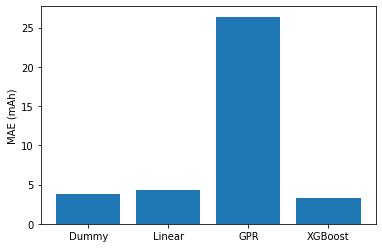

In [26]:
regressors = ['Dummy','Linear','GPR','XGBoost']
maes = [mae_dummy, mae_linear, mae_gpr, mae_xgb]
plt.bar(regressors, maes)
plt.ylabel(r'MAE$_{Test}$ (mAh)')

Only XGBoost is better than the dummy regressor. Visualize the results.

<Figure size 432x288 with 0 Axes>

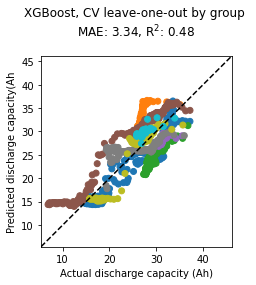

In [27]:
title = "XGBoost, CV leave-one-out by group \n" r"MAE: %0.2f, R$^2$: %0.2f" % (mean_absolute_error(y, y_pred_xgb), r2_score(y, y_pred_xgb))
plotyy(y, y_pred_xgb, eis_data.seriesIdx, title=title)

This is quite a lot better than the linear model, the error is ~10% of the average BOL capacity (35 mAh), and all the trends look correct.

### Model regularization: feature engineering

Feature engineering is a broad term with covering many possible approaches for handling features. Generalizing a bit, there are perhaps three overarching types of feature engineering:
- Feature generation (few features -> many)
    - Ex.: X__i,j = X_i * X_j for all combinations of features i, j
- Feature selection (many features -> few)
    - Ex.: Use impedance data from only 100 Hz
- Feature extraction (many interrelated features -> few independent features)
    - Ex.: Fit ECM to impedance data, use ECM parameters as features

Here, we will study two of the options: feature selection and feature extraction. First, feature selection. We can simply consider a feature selection algorithm that uses only the values from a single frequency. We can automate the extraction of this frequency by defining a class, and passing it to the Pipeline. This might seem like a fair bit of work for a simple operation, but the benefit here is that this is now fully automated, and can happen at any point in an arbitrarily complex sequence of feature transformation operations. 

In [57]:
from sklearn.base import BaseEstimator, TransformerMixin
# Inherent sklearn classes for transformers, this gives us a bunch of methods for free, see sklearn documentation
class SingleFrequencySelector(BaseEstimator, TransformerMixin): 
    def __init__(self, freq, index=0):
        self.freq = freq
        self.index = index
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        n = self.freq.size
        index = [self.index, self.index+n, self.index+n*2, self.index+n*3]
        return X_[:,index]

Test just picking the first frequency.

<Figure size 432x288 with 0 Axes>

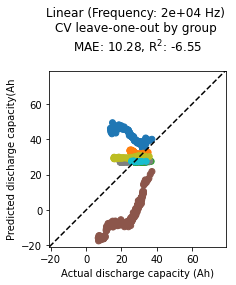

In [102]:
# Linear regression, single frequency
index_freq = 0
pipe_lin_1freq = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('selector', SingleFrequencySelector(freq=freq, index=index_freq)),
        ('regressor', LinearRegression())
    ]
)
# Linear
y_pred_lin_1freq = cross_val_predict(pipe_lin_1freq, x, y, groups=eis_data.seriesIdx, cv=LeaveOneGroupOut())
title = "Linear (Frequency: %0.2g Hz) \n" % (freq[index_freq]) + "CV leave-one-out by group \n" + r"MAE: %0.2f, R$^2$: %0.2f" % (mean_absolute_error(y, y_pred_lin_1freq), r2_score(y, y_pred_lin_1freq))
plotyy(y, y_pred_lin_1freq, eis_data.seriesIdx, title=title)

This wasn't a good guess. But we don't want to manually try all 60 frequencies.

One of the benefits of automation is that we can take advantage of sklearn functionality to automatically grid-search across all possible frequencies.

<Figure size 432x288 with 0 Axes>

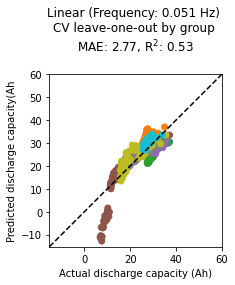

In [127]:
from sklearn.model_selection import GridSearchCV
# Linear regression, single frequency
pipe_lin_1freq = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('selector', SingleFrequencySelector(freq=freq)),
        ('regressor', LinearRegression())
    ]
)
# Parameters of any pipeline step can be sweeped using the name of the step, a dunder '__', and the name of the parameter
param_grid = {
    "selector__index": np.arange(0, freq.size)
}
search = GridSearchCV(pipe_lin_1freq,
    param_grid=param_grid,
    cv=LeaveOneGroupOut(),
    scoring='neg_mean_absolute_error'
)
search.fit(x, y, groups=eis_data.seriesIdx)

# We can make model predictions using the best result exactly the same as before
y_pred_lin_1freq = cross_val_predict(search.best_estimator_, x, y, groups=eis_data.seriesIdx, cv=LeaveOneGroupOut())
title = "Linear (Frequency: %0.2g Hz) \n" % (freq[search.best_params_['selector__index']]) + "CV leave-one-out by group \n" + r"MAE: %0.2f, R$^2$: %0.2f" % (mean_absolute_error(y, y_pred_lin_1freq), r2_score(y, y_pred_lin_1freq))
plotyy(y, y_pred_lin_1freq, eis_data.seriesIdx, title=title)

This is better than the XGBoost model, which has a much more complicated model architecture. All we had to do was find a good frequency. But we're still making some extreme predictions near end-of-life.

We can investigate the MAE versus frequency to help see how the frequency impacts model performance.

Text(0.5, 1.0, 'Linear models, single frequency')

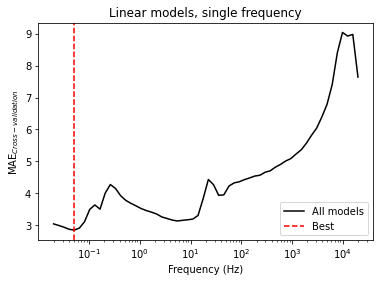

In [128]:
plt.semilogx(freq, -1*search.cv_results_['mean_test_score'], '-k')
plt.axvline(freq[search.best_params_['selector__index']], color='r', linestyle='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'MAE$_{Cross-validation}$')
plt.legend(['All models', 'Best'])
plt.title('Linear models, single frequency')

Note that we are basically constructing our own feature selection method here, and optimizing the hyperparameters of the feature selection algorithm with an exhaustive grid search. For longer searches, sklearn has other tools such as `RandomizedSearchCV`, `HalvingGridSearchCV`, and `HalvingRandomSearchCV`.

To get an idea of how a model is making a prediction, there are many tools we can use to iterrogate a model. Some popular examples include SHAP for estimating contributions of each feature, or partial dependence plots. Note that both of these methods are model agnostic - there are also model specific methods. Here we show partial dependence. Partial dependence shows how the average output value varies when the value of a specific feature is set to a single value across the entire data set and varied across the observed range. We also plot the predicted value from every single row of the data set to show how the results vary independently of the feature being probed by the partial dependence calculation.

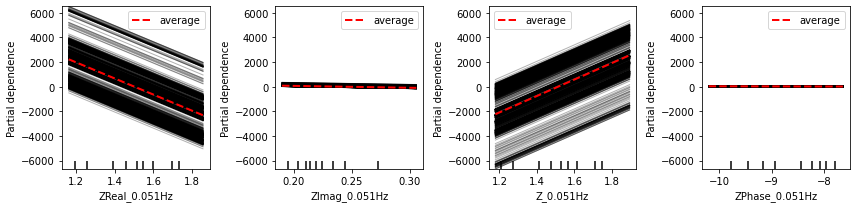

In [152]:
from sklearn.inspection import PartialDependenceDisplay
index_best = search.best_params_['selector__index']
n = freq.size
index_best = [index_best, index_best+n, index_best+n*2, index_best+n*3]
fig, ax = plt.subplots(1, 4, figsize=(12,3))
PartialDependenceDisplay.from_estimator(search.best_estimator_,
    x, features=index_best, kind='both',
    ice_lines_kw = {'linestyle': '-', 'color': 'k', 'linewidth': 1},
    pd_line_kw = {'linestyle': '--', 'color': 'r', 'linewidth': 2},
    ax=ax,
)
plt.tight_layout()

From above, the Z_Real and |Z| features seem by far the most important, but note the y-scale: the impact is huge, causing the expected value of the output to be extreme. Also, our two most important features are cancelling each other out - this implies our model is extremely sensitive, because if we get some values of those two features that are not well covered in our training data, the model prediction may be extremely bad. This is likely what is causing the very poor predictions at low capacity.

Partial dependence can also be done on two features simultaneously, performing a 2D grid search. We can try this on our two most important features to see what happens.

<Figure size 432x288 with 0 Axes>

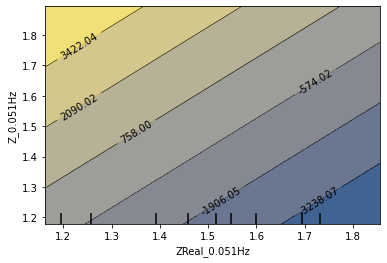

In [159]:
plt.set_cmap('cividis')
PartialDependenceDisplay.from_estimator(search.best_estimator_,
    x, features=[(index_best[0], index_best[2])],
)

We can compare this partial dependence plot to one calculated using an XGBoost estimator to see how different the model structre is. Let's just use the same frequencies, though XGBoost may have a different set of optimal frequencies compared to a linear model.

<Figure size 432x288 with 0 Axes>

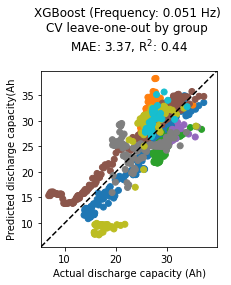

In [160]:
# XGBoost regression, single frequency
index_freq = search.best_params_['selector__index']
pipe_xgb_1freq = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('selector', SingleFrequencySelector(freq=freq, index=index_freq)),
        ('regressor', XGBRegressor())
    ]
)
# Linear
y_pred_xgb_1freq = cross_val_predict(pipe_xgb_1freq, x, y, groups=eis_data.seriesIdx, cv=LeaveOneGroupOut())
title = "XGBoost (Frequency: %0.2g Hz) \n" % (freq[index_freq]) + "CV leave-one-out by group \n" + r"MAE: %0.2f, R$^2$: %0.2f" % (mean_absolute_error(y, y_pred_xgb_1freq), r2_score(y, y_pred_xgb_1freq))
plotyy(y, y_pred_xgb_1freq, eis_data.seriesIdx, title=title)

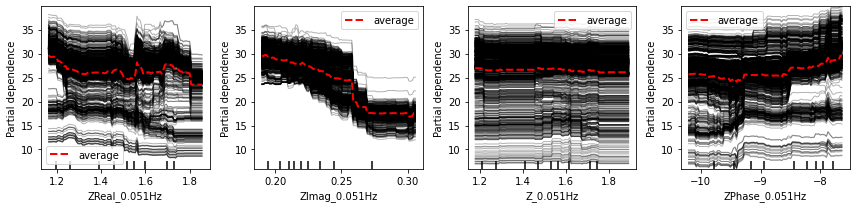

In [162]:
from sklearn.inspection import PartialDependenceDisplay
index_best = search.best_params_['selector__index']
n = freq.size
# Need to fit the model on all data first
pipe_xgb_1freq.fit(x, y)
# Then plot partial dependencies
index_best = [index_best, index_best+n, index_best+n*2, index_best+n*3]
fig, ax = plt.subplots(1, 4, figsize=(12,3))
PartialDependenceDisplay.from_estimator(pipe_xgb_1freq,
    x, features=index_best, kind='both',
    ice_lines_kw = {'linestyle': '-', 'color': 'k', 'linewidth': 1},
    pd_line_kw = {'linestyle': '--', 'color': 'r', 'linewidth': 2},
    ax=ax,
)
plt.tight_layout()

The relationships are obviously non-linear now, and the expected values (y-axis) have become way more reasonable. The second and fourth features seem like the most important.

<Figure size 432x288 with 0 Axes>

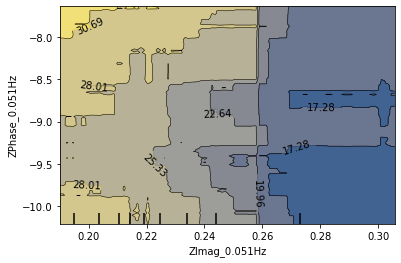

In [163]:
plt.set_cmap('cividis')
PartialDependenceDisplay.from_estimator(pipe_xgb_1freq,
    x, features=[(index_best[1], index_best[3])],
)

Again, the relationships are highly non-linear. It seems like there's two separated 'low capacity' regions, which may correspond to cells showing different behaviors in the training set. But, unlike the linear model, the predictions are much more consistent, not varying wildly outside of the expected range, indicating this model may be more robust to outliers or use in the real-world than the linear model.

It's unlikely that this is the absolute best we can do. We can try other models (support vector regression, XGBoost, GPR), extracting multiple frequencies instead of 1, or trying to use domain knowledge (such as pulling interesting points of the Nyquist plot). For example, sklearn has built-in feature selection methods, such as `SelectKBest`, which only keeps the *k* features that are most highly scored versus the target variable, using some scoring function.

<Figure size 432x288 with 0 Axes>

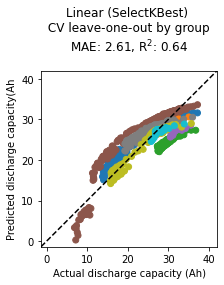

In [129]:
from sklearn.feature_selection import SelectKBest, f_regression
# Linear regression, select best features
pipe_lin_kbest = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(score_func=f_regression, k=4)), # default scoring function is fo
        ('regressor', LinearRegression())
    ]
)
y_pred_lin_kbest = cross_val_predict(pipe_lin_kbest, x, y, groups=eis_data.seriesIdx, cv=LeaveOneGroupOut())
title = "Linear (SelectKBest) \n CV leave-one-out by group \n" + r"MAE: %0.2f, R$^2$: %0.2f" % (mean_absolute_error(y, y_pred_lin_kbest), r2_score(y, y_pred_lin_kbest))
plotyy(y, y_pred_lin_kbest, eis_data.seriesIdx, title=title)

Note that this may be an overestimate of how well this strategy can perform, as the pipeline can select different features during each cross-validation fold. But we can train the model on all data and see what the best features are.

In [130]:
pipe_lin_kbest.fit(x, y)
x.columns[pipe_lin_kbest['selector'].get_support()]

Index(['ZImag_0.064Hz', 'ZImag_0.051Hz', 'ZImag_0.04Hz', 'ZImag_0.032Hz'], dtype='object')

Compare current results:

Text(0, 0.5, 'MAE$_{Test}$ (mAh)')

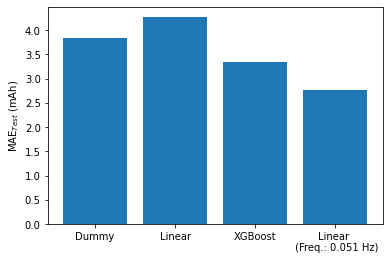

In [164]:
regressors = ['Dummy','Linear','XGBoost',"Linear \n (Freq.: %0.2g Hz)" % (freq[search.best_params_['selector__index']])]
mae_lin_1freq = mean_absolute_error(y, y_pred_lin_1freq)
maes = [mae_dummy, mae_linear, mae_xgb, mae_lin_1freq]
plt.bar(regressors, maes)
plt.ylabel(r'MAE$_{Test}$ (mAh)')

# Challenge
Find a model with lower error than the linear, single frequency model above. Some ideas:
- Search for the best combination of two frequencies
- Use a more complex feature selection strategy 
    - Ex., using feature importance from a `RandomForestRegressor`, see `SelectFromModel`
- Use a different estimator that better handles non-linear relationships
    - Ex., `XBGRegressor`, `SVR`, `GaussianProcessRegressor`
- Extract features using domain knowledge
    - Ex., track minima or maxima from Nyquist plot